# SMO706- Big Data Wrangling 
Tim Hannigan Jan 15, 2019

In [27]:
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [209]:
import re
import sys
import json
import requests
import datetime as dt

!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install bs4
!{sys.executable} -m pip install statsmodels
!{sys.executable} -m pip install matplotlib

import scipy
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import statsmodels
import statsmodels.formula.api as smf

### Main methods

#### Western Canadian Select Oil Price

In [8]:
# first, load the data
file_name = "USCRWCAS_dailyPrice.xlsx"

In [9]:
# next, process it into a DataFrame
df_wcs = pd.read_excel(file_name)
df_wcs.columns = [col.lower() for col in df_wcs.columns] # for ease of use, working with lowercase column names

In [10]:
# this lists the type of variables in the dataframe, note: there are 916 rows
df_wcs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 2 columns):
date        252 non-null datetime64[ns]
uscrwcas    252 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.0 KB


In [11]:
# a shorter way of inspecting this dataframe is by looking at the shape
df_wcs.shape

(252, 2)

In [12]:
# next, inspect the first 5 rows of the data
df_wcs.head(5)

,date,uscrwcas
0,2019-01-14,43.73
1,2019-01-11,44.64
2,2019-01-10,44.74
3,2019-01-09,43.86
4,2019-01-08,40.78


In [13]:
# in order to make this easier to manage, we'll set the index to be the date
df_wcs['date'] = pd.to_datetime(df_wcs['date']) # setting column with 'date' type

In [14]:
# setting the index as date
df_wcs.set_index('date', inplace=True)

In [15]:
# ordering by index (ascending order)
df_wcs.sort_index(axis=0, ascending=True, inplace=True)

In [16]:
# check to see it's working properly
df_wcs.head(2)

,uscrwcas
date,
2018-01-16,42.73
2018-01-17,40.17


In [17]:
# change name of column to make it easier
df_wcs.columns=["wcs"]

In [18]:
# check to see it's working properly
df_wcs.tail(2)

,wcs
date,
2019-01-11,44.64
2019-01-14,43.73


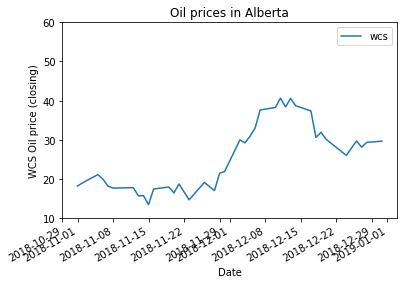

In [19]:
# plotting the late 2018 data
df_wcs.loc['Nov 1, 2018':'Dec 31, 2018', ['wcs']].plot()
plt.ylim(10,60)
plt.xlabel('Date')
plt.ylabel('WCS Oil price (closing)')
plt.title('Oil prices in Alberta')
plt.show()

#### Collect news stories about Alberta + Oil

In [20]:
articles = []
for i in range(1,8):
    with open ("Factiva_major_Canada_news/Factiva"+str(i)+".html", "r") as file: 
        html_doc = file.read()
    soup = BeautifulSoup(html_doc, 'html.parser')
    # in analyzing the HTML source, each story is contained in a div called "article enArticle"
    articleContainers = soup.find_all("div", "article enArticle")
    for articleContainer in articleContainers:
        table = articleContainer.find('table')        
        headline_text = table.find_all("span", "enHeadline")[0].text
        rows = table.find_all('tr')
        article_text = "" # to be filled in below
        for row in rows:
            cols = row.find_all('td')
            if cols[0].text.strip()=="BY": 
                author_text = cols[1].text   
            elif cols[0].text.strip()=="PD": 
                date_text = cols[1].text
                date = pd.to_datetime(date_text) # convert to a date object
            elif cols[0].text.strip()=="LP": # lead paragraph
                article_text += " " + cols[1].text
            elif cols[0].text.strip()=="TD": # content
                article_text += " " + cols[1].text         
        articles.append({"headline": headline_text, "author":author_text, "date": date, "text":article_text })

In [21]:
df_articles = pd.DataFrame(articles)

Review what is in our new dataframe df_articles

In [23]:
df_articles.shape

(629, 4)

In [24]:
df_articles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 4 columns):
author      629 non-null object
date        629 non-null datetime64[ns]
headline    629 non-null object
text        629 non-null object
dtypes: datetime64[ns](1), object(3)
memory usage: 19.7+ KB


#### Now, extract some topics using LDA topic modeling analysis

In [67]:
!{sys.executable} -m pip install gensim
!{sys.executable} -m pip install pyLDAvis
!{sys.executable} -m pip install nltk

# Gensim
import gensim
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# spacy for lemmatization
import spacy

from nltk.corpus import stopwords

In [128]:
# setup the stopword removal
stop_words = stopwords.words('english')
stop_words.extend(["http", "https","www", "com", "say", "said", "html"])

In [129]:
# recall what is in the articles dataframe (df_articles)
df_articles.head(2)

,author,date,headline,text
0,Gillian Steward,2019-01-01,Threats of Alberta separation are mostly an el...,The angry Albertan has struck again.\nAnd he ...
1,Kevin Maimann StarMetro Edmonton,2019-01-01,"Albertans dislike PM the most, poll finds; Gov...",EDMONTON -- Albertans are most likely among C...


In [130]:
df_articles.shape

(629, 4)

This means 629 rows and 4 columns

#### Now, we want to process the "text" column to prepare for LDA topic modeling

In [131]:
# Convert to list
data = df_articles.text.values.tolist()

In [132]:
len(data)

629

At this point, the data variable is a list (629) items long, where each item is an article's content (text)

In [133]:
# we need to turn each article into a list of words (tokens)
# for this we will tokenize words and clean up text using Gensim’s simple_preprocess() method
data_words = []
for article_text in data:
    article_text_cleaned= gensim.utils.simple_preprocess(article_text, deacc=True)  # deacc=True removes punctuations
    data_words.append(article_text_cleaned)

In [134]:
# Need to find phrases in our analysis and collapse them before going further
#Some examples in our example are: ‘alberta_oipatch’, ‘oil_leak’, 'cannabis_oil'

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.

# Faster way to get a sentence clubbed as a bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [135]:
###Remove Stopwords, Make Bigrams and Lemmatize

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [136]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

In [137]:
# Form Bigrams
data_words_with_bigram_phrases = make_bigrams(data_words_nostops)

##### Dictionary and Corpus needed for Topic Modeling

In [138]:
# Create Dictionary
dictionary = gensim.corpora.Dictionary(data_words_with_bigram_phrases) # this keeps track of words through id#

# Term Document Frequency; this converts a document into a bag of words
corpus_bag_of_words = [dictionary.doc2bow(text) for text in data_words_with_bigram_phrases]

In [139]:
# We now have a record of every word in each article (assigned an id#, stored in id2word), and the frequency of each word
print (dictionary.doc2bow(data_words_bigrams[0]) ) 
# this is the representation of the first document in our corpus; note, this is a bag of words, so order has been mixed up, the ids correspond to the dictionary (ie. vocabulary) of the entire corpus

[(0, 1), (1, 1), (2, 1), (3, 15), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 3), (10, 1), (11, 2), (12, 3), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 4), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 2), (31, 1), (32, 1), (33, 1), (34, 2), (35, 1), (36, 2), (37, 1), (38, 2), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 2), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 3), (57, 1), (58, 1), (59, 1), (60, 2), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 2), (69, 1), (70, 1), (71, 1), (72, 2), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 2), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1)

In [140]:
# this is the list of words that make up our first article
print (data_words_with_bigram_phrases[0])

['angry', 'albertan', 'struck', 'sounds', 'like', 'mad', 'hell', 'going', 'take', 'anymore', 'rest', 'canada', 'owes', 'us', 'big', 'time', 'trudeau', 'deliberately', 'wrecking', 'province', 'exactly', 'smartest', 'way', 'win', 'hearts', 'minds', 'across', 'country', 'anger', 'way', 'blotting', 'intelligence', 'regardless', 'certainly', 'lot', 'explosive', 'anger', 'alberta', 'days', 'lot', 'people', 'know', 'better', 'willing', 'throw', 'match', 'anger', 'stems', 'frustration', 'stalled', 'oil', 'pipeline', 'construction', 'pipelines', 'supposed', 'ship', 'alberta', 'plentiful', 'oil', 'supplies', 'united_states', 'export', 'markets', 'limbo', 'mainly', 'objections', 'environmental', 'indigenous', 'activists', 'upheld', 'courts', 'combined', 'complications', 'oil', 'market', 'means', 'alberta', 'oil', 'fetching', 'next', 'nothing', 'compared', 'usual', 'benchmark', 'prices', 'understandably', 'makes', 'lot', 'people', 'mad', 'many', 'depend', 'thriving', 'oil', 'industry', 'well', 'pa

In [141]:
# the first word in this list
data_words_bigrams[0][0]

'angry'

In [142]:
# to look up the id# of this 
dictionary.token2id['angry']

13

In [143]:
# We can also access this word from the dictionary using the id directly
dictionary[13]

'angry'

#### As this point, we can run an LDA model, but we don't yet know the number of topics that best fits our data (something we can figure out later on)

In [144]:
# let's start with 20 topics, just to get a feel for what this means
numberOfTopics = 20

In [145]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_bag_of_words,
                                           id2word=id2word,
                                           num_topics= numberOfTopics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=False)

In [146]:
# Print the Keyword in the topics
topic_output = lda_model.print_topics(numberOfTopics)

for topicTuple in topic_output:
    index = topicTuple[0]+1 # recall that list indices start at 0
    print ("Topic:", index, "\n\t", topicTuple[1])

Topic: 1 
	 0.018*"sdy" + 0.015*"barta" + 0.013*"ostlund" + 0.011*"nsfdf" + 0.011*"srb" + 0.011*"qst" + 0.011*"amortized" + 0.010*"dynamics" + 0.009*"equates" + 0.009*"skewing"
Topic: 2 
	 0.018*"browns" + 0.017*"glee" + 0.012*"pouring" + 0.009*"oscars" + 0.009*"assured" + 0.008*"thiessen" + 0.007*"quarterly_profit" + 0.006*"distinction" + 0.006*"extremities" + 0.005*"classes"
Topic: 3 
	 0.012*"canada" + 0.006*"one" + 0.006*"safety" + 0.005*"new" + 0.005*"year" + 0.005*"canadian" + 0.005*"people" + 0.004*"would" + 0.004*"government" + 0.004*"world"
Topic: 4 
	 0.081*"canelo" + 0.022*"kevin" + 0.015*"legacy" + 0.014*"healing_lodges" + 0.010*"supplied" + 0.010*"licence" + 0.008*"dressing" + 0.008*"poorly" + 0.008*"producer" + 0.007*"damaging"
Topic: 5 
	 0.027*"emissions" + 0.020*"carbon" + 0.015*"living" + 0.013*"cliffhanger" + 0.010*"climate_change" + 0.010*"coach" + 0.009*"canton" + 0.009*"canada" + 0.008*"newfield" + 0.008*"reversion"
Topic: 6 
	 0.032*"litigation" + 0.019*"mr" + 0.

#### Now, to run LDA, We need to the optimal number of topics. We will first use the metric of coherence to see where it maximizes and levels off.

We are going to use a method to track different coherence measures

In [157]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        # Compute Coherence Score        
        lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)                        
        model_list.append(lda_model)
        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')        
        coherence_lda = coherence_model_lda.get_coherence()
        coherence_values.append(coherence_lda)
        print ("trying out, ", num_topics, "topics", "coherence_lda=", coherence_lda)
    return model_list, coherence_values

Given that we have over 500 articles, we should be safe to assume a fit between 10 and 50 topics. First, using steps of 5 

In [158]:
limit=50; start=10; step=5;

In [160]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus_bag_of_words, texts=data_words_with_bigram_phrases, start=start, limit=limit, step=step)

trying out,  10 topics coherence_lda= 0.5028957023257362
trying out,  15 topics coherence_lda= 0.4911158799297805
trying out,  20 topics coherence_lda= 0.5403164667567276
trying out,  25 topics coherence_lda= 0.5455301661373724
trying out,  30 topics coherence_lda= 0.5559148342913124
trying out,  35 topics coherence_lda= 0.5483844728992151
trying out,  40 topics coherence_lda= 0.5700398777622808
trying out,  45 topics coherence_lda= 0.5635353439287198


In [161]:
coherence_values

[0.5028957023257362,
 0.4911158799297805,
 0.5403164667567276,
 0.5455301661373724,
 0.5559148342913124,
 0.5483844728992151,
 0.5700398777622808,
 0.5635353439287198]

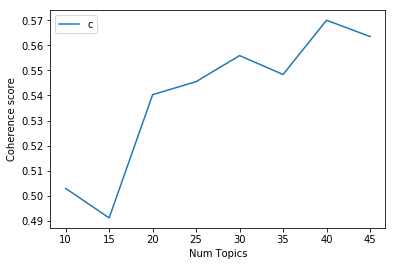

In [162]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [163]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.5029
Num Topics = 15  has Coherence Value of 0.4911
Num Topics = 20  has Coherence Value of 0.5403
Num Topics = 25  has Coherence Value of 0.5455
Num Topics = 30  has Coherence Value of 0.5559
Num Topics = 35  has Coherence Value of 0.5484
Num Topics = 40  has Coherence Value of 0.57
Num Topics = 45  has Coherence Value of 0.5635


In [164]:
idealNumberOfTopics =  40

In [165]:
# Build LDA model
lda_model_optimal = gensim.models.ldamodel.LdaModel(corpus=corpus_bag_of_words,
                                           id2word=id2word,
                                           num_topics= idealNumberOfTopics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=False)

In [166]:
# Print the Keyword in the topics
topic_output = lda_model_optimal.print_topics(idealNumberOfTopics)

for topicTuple in topic_output:
    index = topicTuple[0]+1 # recall that list indices start at 0
    print ("Topic:", index, "\n\t", topicTuple[1])

Topic: 1 
	 0.030*"merrily" + 0.011*"indo" + 0.008*"comparing" + 0.007*"billgraveland" + 0.007*"juice" + 0.006*"aramco" + 0.006*"anytime" + 0.006*"veggies" + 0.005*"antiques" + 0.005*"heroes"
Topic: 2 
	 0.028*"orchard" + 0.018*"classes" + 0.012*"rail_cars" + 0.010*"grappling" + 0.009*"quarterly" + 0.008*"formerly" + 0.007*"economywide" + 0.007*"braced" + 0.006*"hoax" + 0.006*"pegs"
Topic: 3 
	 0.021*"calgary" + 0.018*"cities" + 0.014*"notwithstanding" + 0.009*"texture" + 0.008*"towns" + 0.008*"people" + 0.007*"wannacry" + 0.007*"calf" + 0.006*"goes" + 0.006*"miraculous"
Topic: 4 
	 0.073*"hiatus" + 0.058*"carbon_pricing" + 0.043*"networks" + 0.042*"que" + 0.039*"province" + 0.022*"provinces" + 0.019*"legally" + 0.017*"blackface" + 0.015*"afa" + 0.014*"manitoba"
Topic: 5 
	 0.110*"ensured" + 0.040*"ruffle" + 0.015*"tinker" + 0.010*"motorsports" + 0.010*"shines" + 0.010*"vintage" + 0.008*"pelletier" + 0.007*"proceedings" + 0.005*"masterfully" + 0.005*"merel"
Topic: 6 
	 0.021*"lgbtq" + 

In [167]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_optimal, corpus_bag_of_words, id2word, sort_topics=False)
vis

/Users/Tim/anaconda3/envs/py37/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.121350 -0.019236       1        1   0.143345
1      0.122454 -0.019852       2        1   0.089954
2     -0.116183  0.150468       3        1   1.858002
3      0.067971  0.004937       4        1   0.296006
4      0.118912 -0.018163       5        1   0.048346
5      0.119987 -0.017960       6        1   0.153157
6     -0.080479  0.144332       7        1   1.393138
7      0.119857 -0.020820       8        1   0.092773
8     -0.027388  0.073595       9        1   0.618574
9      0.068320 -0.009203      10        1   0.483024
10     0.110111 -0.019280      11        1   0.188899
11     0.116698 -0.021704      12        1   0.159440
12     0.104454 -0.019288      13        1   0.202812
13     0.119071 -0.021486      14        1   0.117146
14     0.121116 -0.017488      15        1   0.066898
15    -0.310108 -0.198503      16        1  16.464315
16    -0.336561 -0.168983      17        1   6.990373
17    -0.091548  0.224766      18        1   1.942870
18    -0.228569  0.164653      19        1  14.817274
19    -0.354520 -0.093452      20        1   9.467410
20     0.119693 -0.012989      21        1   0.025966
21     0.044341 -0.054980      22        1   0.445503
22     0.035382  0.022783      23        1   0.600676
23     0.116179 -0.020230      24        1   0.134663
24     0.098722 -0.018570      25        1   0.213475
25     0.083879  0.000204      26        1   0.320488
26     0.121397 -0.017886      27        1   0.132863
27    -0.321099  0.018383      28        1  24.685406
28     0.083743  0.005859      29        1   0.591393
29     0.120469 -0.019937      30        1   0.128096
30    -0.284676 -0.111478      31        1   4.718179
31     0.122411 -0.019307      32        1   0.039066
32     0.121193 -0.019452      33        1   0.026443
33     0.098685 -0.020801      34        1   0.154816
34    -0.240863  0.137082      35        1   4.422391
35    -0.245459  0.062501      36        1   5.436084
36    -0.034763 -0.076225      37        1   0.716319
37     0.015870  0.067854      38        1   0.926648
38     0.062933 -0.006392      39        1   0.685597
39     0.117018 -0.013753      40        1   0.002175, topic_info=      Category         Freq            Term        Total  loglift  logprob
term                                                                      
180    Default  3478.000000             oil  3478.000000  30.0000  30.0000
510    Default   797.000000              mr   797.000000  29.0000  29.0000
6842   Default  1443.000000           testy  1443.000000  28.0000  28.0000
399    Default  1819.000000        per_cent  1819.000000  27.0000  27.0000
38     Default  3299.000000          canada  3299.000000  26.0000  26.0000
7656   Default   794.000000       pertinent   794.000000  25.0000  25.0000
389    Default  1503.000000             new  1503.000000  24.0000  24.0000
208    Default   668.000000        province   668.000000  23.0000  23.0000
341    Default  1436.000000          energy  1436.000000  22.0000  22.0000
115    Default   867.000000             gas   867.000000  21.0000  21.0000
36     Default   954.000000         calgary   954.000000  20.0000  20.0000
15     Default  1146.000000         article  1146.000000  19.0000  19.0000
8770   Default   690.000000       sensitive   690.000000  18.0000  18.0000
51     Default   659.000000       companies   659.000000  17.0000  17.0000
296    Default   635.000000           words   635.000000  16.0000  16.0000
883    Default   554.000000          cities   554.000000  15.0000  15.0000
3      Default  2035.000000         alberta  2035.000000  14.0000  14.0000
1057   Default  1001.000000          safety  1001.000000  13.0000  13.0000
181    Default  1339.000000             one  1339.000000  12.0000  12.0000
6088   Default   515.000000     photographs   515.000000  11.0000  11.0000
3830   Default  1194.000000         pro

In [ ]:
# from this, you can see that topic 23 is about production cuts in Alberta and OPEC, topic 7 is about increasing production, topic 10 is about pipelines

#### Looking at output from the LDA model

In [51]:
# Reference: https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/topic_methods.ipynb

In [170]:
len(corpus_bag_of_words)

629

In [171]:
len(lda_model_optimal[corpus_bag_of_words])

629

#### Topic distribution across documents

In [172]:
topics_in_each_document = lda_model_optimal.get_document_topics(corpus_bag_of_words, per_word_topics=False, minimum_probability=0.0)
# this will output the relevant topics per document

In [173]:
# one probability weight for each topic in this document
topics_in_each_document[4]

[(0, 6.507472e-05),
 (1, 6.818255e-05),
 (2, 0.07048253),
 (3, 0.00015465697),
 (4, 4.734948e-05),
 (5, 0.20177276),
 (6, 0.00036079553),
 (7, 6.908857e-05),
 (8, 0.012016157),
 (9, 0.0032227254),
 (10, 0.03709918),
 (11, 6.8722504e-05),
 (12, 3.9393486e-05),
 (13, 5.7815854e-05),
 (14, 5.1720377e-05),
 (15, 0.09490907),
 (16, 0.024237012),
 (17, 0.00016383888),
 (18, 0.06510961),
 (19, 0.08303601),
 (20, 3.381427e-05),
 (21, 0.00013131257),
 (22, 0.00029231756),
 (23, 8.076925e-05),
 (24, 3.910511e-05),
 (25, 9.4250885e-05),
 (26, 0.00012346753),
 (27, 0.31681228),
 (28, 6.507199e-05),
 (29, 8.321873e-05),
 (30, 0.0058902483),
 (31, 3.8716127e-05),
 (32, 2.817325e-05),
 (33, 0.00017213814),
 (34, 0.08178082),
 (35, 0.0008810606),
 (36, 0.00023762062),
 (37, 7.72496e-05),
 (38, 8.319079e-05),
 (39, 2.3485567e-05)]

In [174]:
# creating a document_topic_matrix for all topics, all documents

In [175]:
topic_document_matrix = []
for document_topics in topics_in_each_document:
    tdm = {}
    for topicFound in document_topics:
        topicID = topicFound[0]
        topicValue = topicFound[1]
        tdm[topicID] = topicValue # set value
    topic_document_matrix.append(tdm)
tdm_df = pd.DataFrame(topic_document_matrix)        

In [176]:
# change order of columns
columns = ["topic_"+str(i) for i in range(1,idealNumberOfTopics+1)]

In [177]:
tdm_df.columns = columns

In [178]:
tdm_df.head()

,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,...,topic_31,topic_32,topic_33,topic_34,topic_35,topic_36,topic_37,topic_38,topic_39,topic_40
0,0.000055,0.000057,0.013919,0.000130,0.000040,0.000085,0.000303,0.000058,0.000210,0.000171,...,0.000480,0.000033,0.000024,0.000145,0.013106,0.000736,0.000200,0.000065,0.000070,0.000020
1,0.000083,0.000087,0.035078,0.000197,0.000060,0.000129,0.000459,0.000088,0.000318,0.000260,...,0.000708,0.000049,0.000036,0.000219,0.000604,0.006465,0.000302,0.000098,0.000106,0.000030
2,0.000074,0.000078,0.000549,0.000176,0.025697,0.000116,0.000412,0.000079,0.000285,0.000233,...,0.000636,0.000044,0.000032,0.000196,0.071155,0.028440,0.000271,0.079419,0.003331,0.000027
3,0.000167,0.000175,0.001239,0.000396,0.000121,0.000260,0.000925,0.000177,0.000640,0.034790,...,0.001433,0.000099,0.000072,0.000441,0.001227,0.002402,0.000609,0.000198,0.000213,0.000060
4,0.000065,0.000068,0.070484,0.000155,0.000047,0.201771,0.000361,0.000069,0.012005,0.003223,...,0.005889,0.000039,0.000028,0.000172,0.081775,0.000881,0.000238,0.000077,0.000083,0.000023


In [179]:
# this will calculate the dominant topic per document, recall this starts from 0
dominant_topic = np.argmax(tdm_df.values, axis=1)

In [180]:
tdm_df['dominant_topic'] = dominant_topic+1 # using index starting from 1

In [181]:
combined_tdm = pd.concat([df_articles, tdm_df], axis=1) 

In [182]:
#combined_tdm.loc[4].text

In [183]:
combined_tdm.head(3)

,author,date,headline,text,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_32,topic_33,topic_34,topic_35,topic_36,topic_37,topic_38,topic_39,topic_40,dominant_topic
0,Gillian Steward,2019-01-01,Threats of Alberta separation are mostly an el...,The angry Albertan has struck again.\nAnd he ...,0.000055,0.000057,0.013919,0.000130,0.000040,0.000085,...,0.000033,0.000024,0.000145,0.013106,0.000736,0.000200,0.000065,0.000070,0.000020,28
1,Kevin Maimann StarMetro Edmonton,2019-01-01,"Albertans dislike PM the most, poll finds; Gov...",EDMONTON -- Albertans are most likely among C...,0.000083,0.000087,0.035078,0.000197,0.000060,0.000129,...,0.000049,0.000036,0.000219,0.000604,0.006465,0.000302,0.000098,0.000106,0.000030,28
2,Kevin Maimann StarMetro Edmonton,2019-01-01,Our annual predictions for the year ahead,"S o long, 2018. The year started with Virtue ...",0.000074,0.000078,0.000549,0.000176,0.025697,0.000116,...,0.000044,0.000032,0.000196,0.071155,0.028440,0.000271,0.079419,0.003331,0.000027,20


In [184]:
combined_tdm.to_csv("combined_tdm.csv")

### Now, set up regression

Note: this is not the best setup for an OLS regression. You might want to explore GLM models as this currently resembles panel data.

In [185]:
combined_tdm['date'] = pd.to_datetime(combined_tdm['date']) # convert to a date object
# sort by date, then can create a lag using shift(x).rolling()
combined_tdm.sort_values(by='date', ascending=True, inplace=True)

In [186]:
combined_tdm.tail(2)

,author,date,headline,text,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,...,topic_32,topic_33,topic_34,topic_35,topic_36,topic_37,topic_38,topic_39,topic_40,dominant_topic
1,Kevin Maimann StarMetro Edmonton,2019-01-01,"Albertans dislike PM the most, poll finds; Gov...",EDMONTON -- Albertans are most likely among C...,0.000083,0.000087,0.035078,0.000197,0.00006,0.000129,...,0.000049,0.000036,0.000219,0.000604,0.006465,0.000302,0.000098,0.000106,0.00003,28
0,Gillian Steward,2019-01-01,Threats of Alberta separation are mostly an el...,The angry Albertan has struck again.\nAnd he ...,0.000055,0.000057,0.013919,0.000130,0.00004,0.000085,...,0.000033,0.000024,0.000145,0.013106,0.000736,0.000200,0.000065,0.000070,0.00002,28


In [187]:
# for this, we need one row for each day, aggregating articles and oil price on that day - recall I need to lag this after
# range will be Nov 1 2018 - Jan 1 2019
days_to_analyze = []
start = dt.datetime(2018,11,1)
std_date_format = '%Y-%m-%d'    
for i in range(0,60):
    day = {}
    dateToProcess = start+ dt.timedelta(days=i)
    day['date']= dateToProcess
    #print (dateToProcess.strftime(std_date_format)) 
    # bring in WCS price for that day, ignore weekends
    if dateToProcess in df_wcs.index:
        day['wcs'] = df_wcs.loc[dateToProcess]['wcs']        
        # aggregate all articles for that day
        articlesInDay = combined_tdm[combined_tdm['date']==dateToProcess]
        if len(articlesInDay)>0:
            day['articlesInDay']= len(articlesInDay)
            for i in range(1,idealNumberOfTopics+1):
                # form aggregate topic weights in day
                day["topic_"+str(i)] = articlesInDay["topic_"+str(i)].sum()
            days_to_analyze.append(day) # only focus on days with coverage to simplify things   

In [188]:
df_daily = pd.DataFrame(days_to_analyze)

In [189]:
# setup 5 day lag
for i in range(1,idealNumberOfTopics+1):
    df_daily["topic_"+str(i)+"_5_dayLag"] = df_daily["topic_"+str(i)].shift(1).rolling(5).mean()
    df_daily["articles_5_dayLag"] = df_daily["articlesInDay"].shift(1).rolling(5).sum()

In [190]:
df_daily.head(10)

,articlesInDay,date,topic_1,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,...,topic_31_5_dayLag,topic_32_5_dayLag,topic_33_5_dayLag,topic_34_5_dayLag,topic_35_5_dayLag,topic_36_5_dayLag,topic_37_5_dayLag,topic_38_5_dayLag,topic_39_5_dayLag,topic_40_5_dayLag
0,13,2018-11-01,0.007161,0.008318,0.008024,0.002407,0.000615,0.002531,0.003378,0.734076,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,2018-11-02,0.001098,0.003050,0.001576,0.000709,0.014129,0.000257,0.000230,0.195099,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7,2018-11-05,0.002161,0.004256,0.128867,0.006231,0.000277,0.001216,0.000364,0.439931,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,12,2018-11-06,0.005096,0.020148,0.009008,0.002966,0.002901,0.000561,0.000502,0.801467,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6,2018-11-07,0.007441,0.014606,0.010937,0.003326,0.008095,0.002614,0.002864,0.461260,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,14,2018-11-08,0.011332,0.055486,0.013386,0.072385,0.111243,0.013910,0.000329,5.951260,...,0.400420,0.017089,0.027605,0.055925,0.232308,0.626846,0.014471,0.019595,0.010399,0.000189
6,10,2018-11-13,0.000255,0.032935,0.002734,0.004069,0.050894,0.121247,0.000203,5.601712,...,0.429718,0.016946,0.000175,0.026461,0.205569,0.564093,0.021081,0.015321,0.007079,0.000146
7,29,2018-11-14,0.002832,0.423797,0.022633,0.116281,0.013150,0.012367,0.001074,10.837961,...,0.434444,0.012379,0.000172,0.027840,0.198086,0.504437,0.034613,0.009005,0.006784,0.000144
8,17,2018-11-15,0.003861,0.036003,0.017812,0.077624,0.017193,0.016044,0.000995,4.352560,...,0.463585,0.012350,0.010912,0.030322,0.158945,0.603128,0.109817,0.013953,0.011921,0.000208
9,12,2018-11-16,0.002112,0.122341,0.011834,0.006793,0.077515,0.005162,0.000497,3.232107,...,0.522585,0.013751,0.010966,0.028341,0.253167,0.580991,0.121864,0.013466,0.012869,0.000318


In [203]:
# for analysis, we need to drop the first 5 observations
df_daily_analysis = df_daily[5:].copy()

### Now, do the analysis with a simple OLS regression

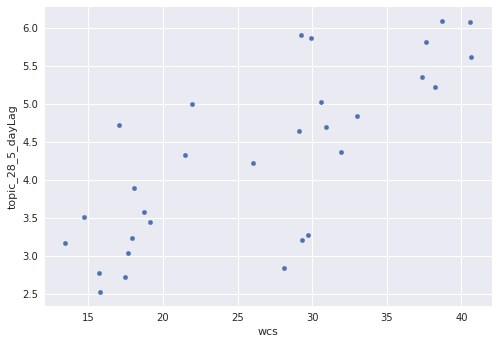

In [202]:
plt.style.use('seaborn')

df_daily_analysis.plot(x='wcs', y='topic_28_5_dayLag', kind='scatter')
plt.show()

In [205]:
model = smf.ols('wcs ~ articles_5_dayLag + topic_28_5_dayLag', data=df_daily_analysis).fit()

In [207]:
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                    wcs   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.592
Method:                 Least Squares   F-statistic:                     22.06
Date:                Tue, 15 Jan 2019   Prob (F-statistic):           2.10e-06
Time:                        16:53:01   Log-Likelihood:                -92.321
No. Observations:                  30   AIC:                             190.6
Df Residuals:                      27   BIC:                             194.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             5.7713      4.73